# CSE152B: Homework 1
## Computing Resources
Please read the README file of this repository for the instructions.

## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Mon, May 4, by 4pm PST.

## Question 1: Warm Up

We will first try SFM using the original implementation from [$\mathtt{libviso2}$](http://www.cvlibs.net/software/libviso/) (we wrapped it with Python wrappers at ``pyviso/src``). We will test on a dataset containing 300 images from one sequence of the KITTI dataset with ground-truth camera poses and camera calibration information. 

Run the SFM algorithm using the following script. You are required to report two error metrics. The error metric for rotation is defined as the mean of Frobenius norm of the difference between the ground-truth rotation matrix and predicted rotation matrix. The error metric for translation is defined as mean of the L2 distance. Both errors will be printed on the screen as you run the code.  **(5 points)**

In [1]:
import os
import sys
# change your base path
os.chdir('./pyviso/') # './'
print(os.getcwd())

/datasets/home/home-00/04/004/rcrenter/cse152b-hw1-release/pyviso


In [2]:
import os
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = True # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
# dataset_path = '../dataset'
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)

if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
    else:
        plt.ioff()

In [ ]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

for frame in range(first_frame, last_frame):
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p

    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p

    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)

    print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1+epi)))
    print('Mean Error Translation: %.5f'%(errorTransSum / (k-1+epi)))

    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0 or frame == last_frame-1:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()


# input('Press Enter to exit')

1. Report the final rotation and translation error. **(2 points)**

``Rotation Error: 0.00277``

``Translation Error: 0.53721``

Then answer the questions below

2. In $\mathtt{libviso2}$, the feature points are "bucketed" ($\mathtt{pyviso/src/matcher.cpp: Line 285 - 326}$), which means in a certain area of region, the number of detected keypoint pairs should be within certain bounds. Why?  **(3 points)**

``Because of our assumption of realtively small motion, we can expect the corresponding pair of pixels to not differ too much in postion from each other``

3. We have run SFM on a single camera, which means the scale of translation is unknown. However, as you may have observed, the predicted trajectory is still somehow similar to the ground-truth trajectory. How does $\mathtt{libviso2}$ handle this ambiguity ($\mathtt{viso\_mono.cpp: Line 245}$)?  **(5 points)**

``It seems as thought they use a parameter passed in as some sort of default for that part in the equation``

4. Briefly explain the RANSAC algorithm used in $\mathtt{libviso2}$ ($\mathtt{viso\_mono.cpp: Line 113 - 129}$).  **(5 points)**

``they randomly selected their sample set out of pairs of matched points, they then computer the fundamental matrix with those points, and utilized the number of inliers as a metric to measure this iteration in comparison to the previous iterations, we are left with the F with the most inliers by the end``

## Question 2: Using SIFT [4] for SFM

In the second task, you are required to use keypoints and feature descriptors from SIFT for SFM. The SIFT implementation can be found in directory $\mathtt{SIFT}$. 

(A) Go to $\mathtt{SIFT}$ directory and run $\mathtt{runSIFT.py}$ (e.g. `python runSIFT.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/`). You will save the detected keypoints and feature descriptors under the directory $\mathtt{SIFT}$. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable should be a $130 \times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $130$-dimensional feature vector, the first two dimensions are the location of the keypoints (column number first and then row number) on the image plane and the last $128$ dimensions are the feature descriptor. 

(B) Run the following script

In [ ]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SIFT'
runFeature.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

``Rotation Error: 0.00243
 Translation Error: 0.55841``

Next, answer the following questions:

2. Does SIFT yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, can you suggest one possible way to improve? **(5 points)**

``SIFT does not yield higher accuracy than libviso2, it seems to be because there is no threshold for the proximities of the paired points. My suggestion would be to exclude selections with the movement further than a certain threshold``

3. Explain how SIFT achieves invariance to 
       a. illumination
       b. rotation
       c. scale
 **(3 points)**

``A) SIFT uses slope of pixel intensities in relation to each other, so differences in light intensity affects most of the pixels over its window, and so the slopes are generally unaffected.
B) SIFT normalizes the orientation such that it gets the highest possible score, this brings an invarience to orientation, or rotation.
C) SIFT changes the sizes of its comparisons to provide some invariance to scale``

## Question 3: Using SPyNet [5] for SFM

Now we will compute camera motion from optical flow computed using SPyNet. We first uniformly sample points in an image, then consider the flow-displaced point in the other image as a match. A modified PyTorch implementation of SPyNet is provided in directory  $\mathtt{Flow}$.

(A) Go to $\mathtt{Flow}$ and run $\mathtt{demo\_spynet.py}$. 

(B) Run the following script.

In [ ]:
import runMatch
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'Flow'
runMatch.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

``Rotation Error: 0.0038
 Translation Error: 0.61071``

Next, answer the following questions:

2. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, what steps can you take to improve? **(5 points)**

``spyNet does not yeild higher accuracy than libviso2, this is due to what spynet is optimizing, it downsamples and computes the distance based on how far from the ground truth it is in the sample that it is in, then upsamples and calculates again, this optimizes the difference at every sample. for improvement, perhaps optimizing more of the upsampled version``

3. Explain how SPyNet achieves accurate flow with significantly lower computational cost. **(3 points)**

``Spynet achieves accurate flow with less computation cost because it tries to optimize residual flow at each upsampling. Because we are only calculating the residuals at each layer, the computation cost is less``

## Question 4: Optical Flow with Lucas-Kanade (LK) [7]

In this question you are going to implement the Lucas-Kanade algorithm and test it on a image sequence.

1. Implement the Lucas-Kanade method for estimating optical flow. The function ``def LucasKanadeOpticalFlow(im1,im2,window)`` needs to be completed and it can then be used for the main script in the second block.  **(5 points)**

``answer in the code block below``

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from numpy import linalg

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t = 10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()



def LucasKanadeOpticalFlow(im1,im2,window):
    '''
    Implement the Lucas-Kanade algorithm
    Inputs: the two images, window size
    Returns: u, v - the optical flow
    '''
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    
#     temporalImg = np.dstack((grayIm1, grayIm1, grayIm2))
    partialT = im1 - im2 #np.squeeze(convolve(temporalImg, np.array([[[1]], [[0]], [[-1]]]).T, mode='valid'))
    
    partialX = convolve(im2, np.array([[-1,0,1]]), mode='same')
    partialY = convolve(im2, np.array([[-1,0,1]]).T, mode='same')
    partialX2 = np.square(partialX)
    partialY2 = np.square(partialY)
    partialXY = partialX * partialY
    partialXT = partialX * partialT
    partialYT = partialY * partialT
    
    # Creating the summation matrices
    sumX2 = convolve(partialX2, np.ones((window, window)), mode='same')
    sumXY = convolve(partialXY, np.ones((window, window)), mode='same')
    sumY2 = convolve(partialY2, np.ones((window, window)), mode='same')
    sumXT = convolve(partialXT, np.ones((window, window)), mode='same')
    sumYT = convolve(partialYT, np.ones((window, window)), mode='same')
    
    U = []
    V = []
    
    for tL,bR,tR,timeTop,timeBot in zip(np.nditer(sumX2), np.nditer(sumY2), np.nditer(sumXY), np.nditer(sumXT), np.nditer(sumYT)):
        M = np.array([[tL, tR], [tR, bR]])
        b = -np.array([[timeTop], [timeBot]])
        u = np.matmul(linalg.inv(M), b)
        U.append(u[0])
        V.append(u[1])
        
    
    U = np.reshape(np.asarray(U), im1.shape)
    V = np.reshape(np.asarray(V), im1.shape)
    
    return U,V

2. Plot optical flow for the three choices for pair of images im1 and im2 specified below, using windows size of 13. For each plot, comment on whether and how the estimated flow matches your the motion visible in the image pair.  **(6 points)**

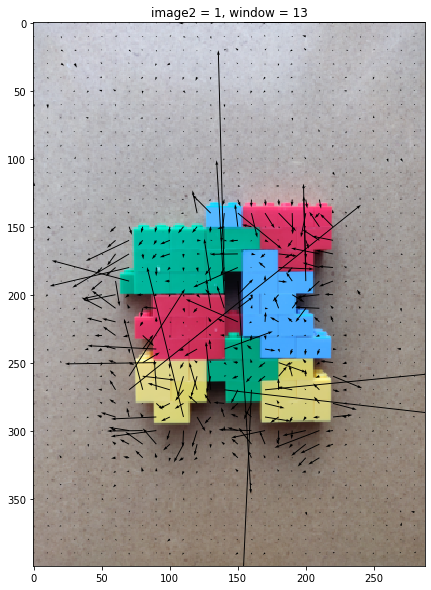

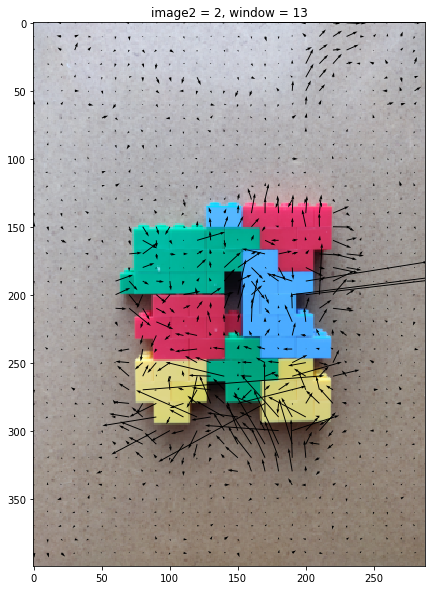

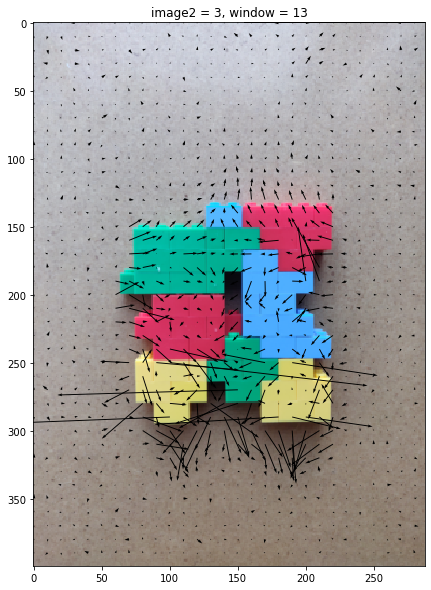

In [4]:
images = []
for i in range(1,5):
    images.append(plt.imread('../OpticalFlowImages/im'+str(i)+'.png')[:,:288,:])
# each image after converting to gray scale is of size -> 400x288

window = 13
U, V = LucasKanadeOpticalFlow(grayscale(images[0]),grayscale(images[1]), window)
plot_optical_flow(images[0], U, V, 'image2 = ' + str(1) + ', window = ' + str(window))

window = 13
U, V = LucasKanadeOpticalFlow(grayscale(images[0]),grayscale(images[2]), window)
plot_optical_flow(images[0], U, V, 'image2 = ' + str(2) + ', window = ' + str(window))

window = 13
U, V = LucasKanadeOpticalFlow(grayscale(images[0]),grayscale(images[3]), window)
plot_optical_flow(images[0], U, V, 'image2 = ' + str(3) + ', window = ' + str(window))

``For the first plot the flow estimation seems to be nearly completely random``

``For the second plot, there seems to be a slight trend to flow moving upwards on the top right, and then flow on the top left going down slightly, which indicates a small rotation, which is what we have``

``For the last plot, the flow seems to be travelling upwards. the photots seem to indicate no motion, however``

3. For the first pair of images above, estimate optical flow using one smaller and one larger window, which lead to observable difference in the results. Comment on the effect of window size on results and justify.  **(4 points)**

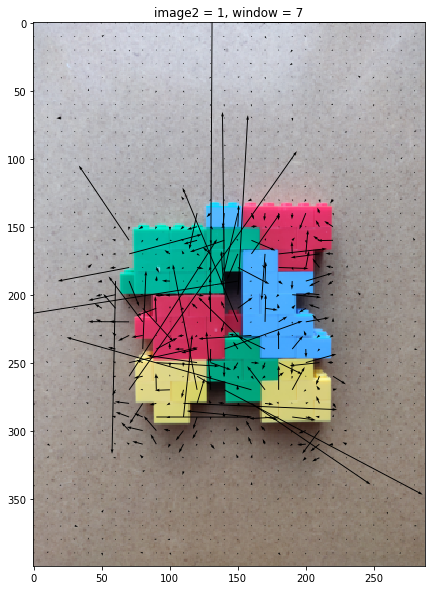

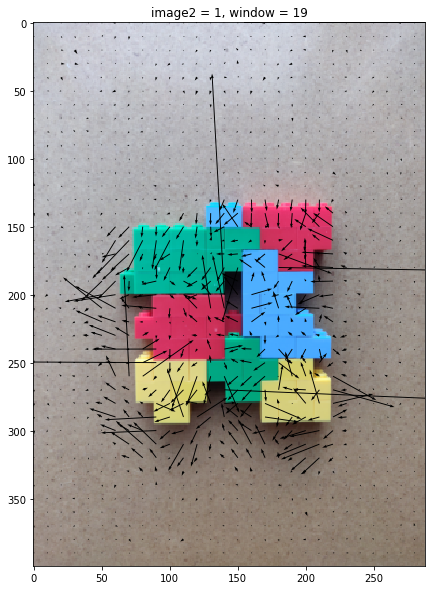

In [5]:
window = 7
U, V = LucasKanadeOpticalFlow(grayscale(images[0]),grayscale(images[1]), window)
plot_optical_flow(images[0], U, V, 'image2 = ' + str(1) + ', window = ' + str(window))

window = 19
U, V = LucasKanadeOpticalFlow(grayscale(images[0]),grayscale(images[1]), window)
plot_optical_flow(images[0], U, V, 'image2 = ' + str(1) + ', window = ' + str(window))

``it appears that larger windows allow for more consistency across the object, but seems to place more vectors that are not on the object itself, while th esmaller window size places mostly on the object, but has less consistency``

### Notes:
- scp data to local machines:

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/sfmlearner_h128w416.zip`

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/kitti.zip`
...

# References
1. Daniel DeTone, Tomasz Malisiewicz, and Andrew Rabinovich. Superpoint: Self-supervised interest point detection and description. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops, pages 224–236, 2018.
2. Andreas Geiger, Philip Lenz, and Raquel Urtasun. Are we ready for autonomous driving? the kitti vision benchmark suite. In Conference on Computer Vision and Pattern Recognition (CVPR), 2012.
3. Andreas Geiger, Julius Ziegler, and Christoph Stiller. Stereoscan: Dense 3d reconstruction in real-time. In Intelligent Vehicles Symposium (IV), 2011.
4. David G Lowe. Distinctive image features from scale-invariant keypoints. IJCV, 60(2):91–110, 2004.
5. Anurag Ranjan and Michael J Black. Optical flow estimation using a spatial pyramid network. In
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 4161–4170, 2017.
6. A. Vedaldi and B. Fulkerson. VLFeat: An open and portable library of computer vision algorithms. http://www.vlfeat.org/, 2008.
7. Lucas, Bruce D., and Takeo Kanade. "An iterative image registration technique with an application to stereo vision." (1981): 674.